In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
from surprise.dump import load
from sklearn.manifold import TSNE

In [2]:
# Load the model (trained on the first 10 percent of data)
model = load('models/10p_svd_model.pickle')[1]
n_movies = model.trainset.n_items

In [43]:
def plot_graph(df2, colname, show=False):
    plt.figure(figsize=(12, 12))
    sns.scatterplot(
        x=df2['latent_x'], y=df2['latent_y'],
        hue=df2[colname],
        data=df2
    )
    plt.xlabel('Latent factor 1')
    plt.ylabel('Latent factor 2')
    plt.title('First 10 percent of movies plotted with {}'.format(colname))
    if show:
        plt.show()

Let's begin with some general investigations of the genres we have available

In [4]:
# read all of the genres into a list
df = pd.read_csv('./data/nflx_imdb_interscetion.csv')
df = df.head(n_movies) # only working with the first 10p of movies

# create counter which 
genres_list = df['genres'].dropna()
genres_list = [x.split(',') for x in genres_list]
flattened_genres = [item for sublist in genres_list for item in sublist]
count_dict = Counter(flattened_genres)
count_dict.most_common()

[('Drama', 614),
 ('Comedy', 426),
 ('Action', 237),
 ('Romance', 228),
 ('Crime', 221),
 ('Adventure', 154),
 ('Thriller', 140),
 ('Horror', 112),
 ('Documentary', 99),
 ('Sci-Fi', 73),
 ('Family', 70),
 ('Mystery', 69),
 ('Music', 67),
 ('Animation', 64),
 ('Fantasy', 62),
 ('Biography', 58),
 ('History', 44),
 ('War', 33),
 ('Musical', 27),
 ('Western', 22),
 ('Short', 15),
 ('Film-Noir', 11),
 ('Sport', 11),
 ('Adult', 3),
 ('Talk-Show', 1),
 ('Game-Show', 1),
 ('Reality-TV', 1)]

## MOst Common
For each movie which has multiple labels, let's only keep the label which appears the most often in the data

In [5]:
def keep_most_common_genre(genres_string, most_common_dict):
    if not type(genres_string) == str:
        return ''
    genres = genres_string.split(',')
    mx = 0
    most_common = ''
    for genre in genres:
        if most_common_dict[genre] > mx:
            mx = most_common_dict[genre]
            most_common = genre
            
    return most_common

df['most_common_genre'] = df.genres.apply(lambda x: keep_most_common_genre(x, count_dict))

In [6]:
df['latent_x'] = model.qi[:, 0]
df['latent_y'] = model.qi[:, 1]

df.head()

,Unnamed: 0,ID,year,title,lower_no_punct,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,most_common_genre,latent_x,latent_y
0,0,1,2003.0,Dinosaur Planet,dinosaur planet,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0.0,2003.0,NaN,50.0,"Animation,Documentary,Family",Documentary,0.041097,0.015428
1,1,2,2004.0,Isle of Man TT 2004 Review,isle of man tt 2004 review,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.037217,0.040106
2,2,3,1997.0,Character,character,tt0119448,movie,Character,Karakter,0.0,1997.0,NaN,122.0,"Crime,Drama,Mystery",Drama,0.136981,-0.046795
3,3,4,1994.0,Paula Abdul's Get Up & Dance,paula abdul's get up & dance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.023480,-0.180581
4,4,5,2004.0,The Rise and Fall of ECW,the rise and fall of ecw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.509288,0.409588


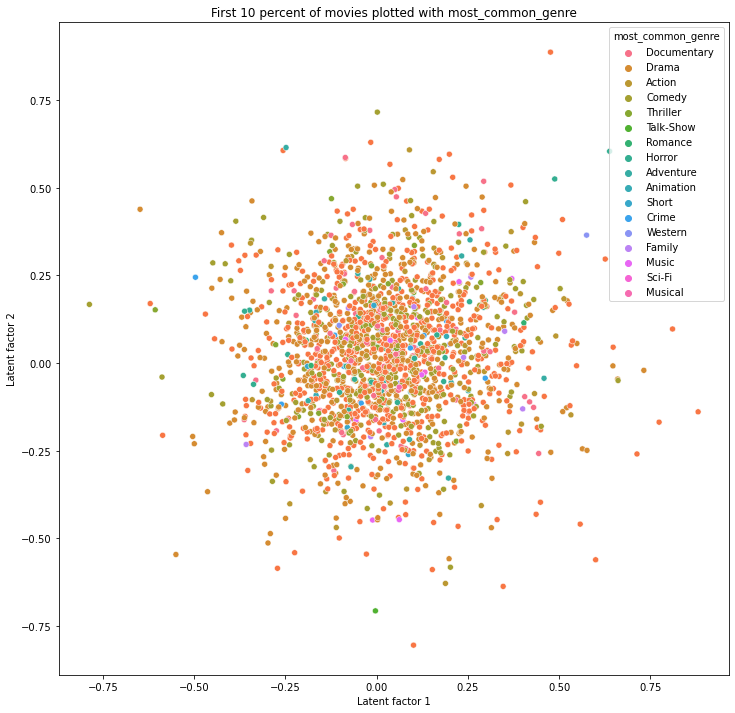

In [7]:
plot_graph(df, colname='most_common_genre')

## Unique genres
Keep the genres as they are, and graph them that way. I. E. If a movie is an action-drama-comedy, let's graph it that way

In [8]:
def unique_genre(x):
    if type(x) != str:
        return ''
    return '_'.join(sorted(x.lower().split(',')))

df['unique_genres'] = df.genres.apply(lambda x: unique_genre(x))
df.head()

,Unnamed: 0,ID,year,title,lower_no_punct,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,most_common_genre,latent_x,latent_y,unique_genres
0,0,1,2003.0,Dinosaur Planet,dinosaur planet,tt0389605,tvMiniSeries,Dinosaur Planet,Dinosaur Planet,0.0,2003.0,NaN,50.0,"Animation,Documentary,Family",Documentary,0.041097,0.015428,animation_documentary_family
1,1,2,2004.0,Isle of Man TT 2004 Review,isle of man tt 2004 review,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.037217,0.040106,
2,2,3,1997.0,Character,character,tt0119448,movie,Character,Karakter,0.0,1997.0,NaN,122.0,"Crime,Drama,Mystery",Drama,0.136981,-0.046795,crime_drama_mystery
3,3,4,1994.0,Paula Abdul's Get Up & Dance,paula abdul's get up & dance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.023480,-0.180581,
4,4,5,2004.0,The Rise and Fall of ECW,the rise and fall of ecw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.509288,0.409588,


In [9]:
# plot_graph(df, colname='unique_genres')

## Plot with tent-poles
The above graph is very hard to read. Another idea might be to start with the movies which only have one label, plot those, and hope that some sort of "center of gravity" arises from this plotting

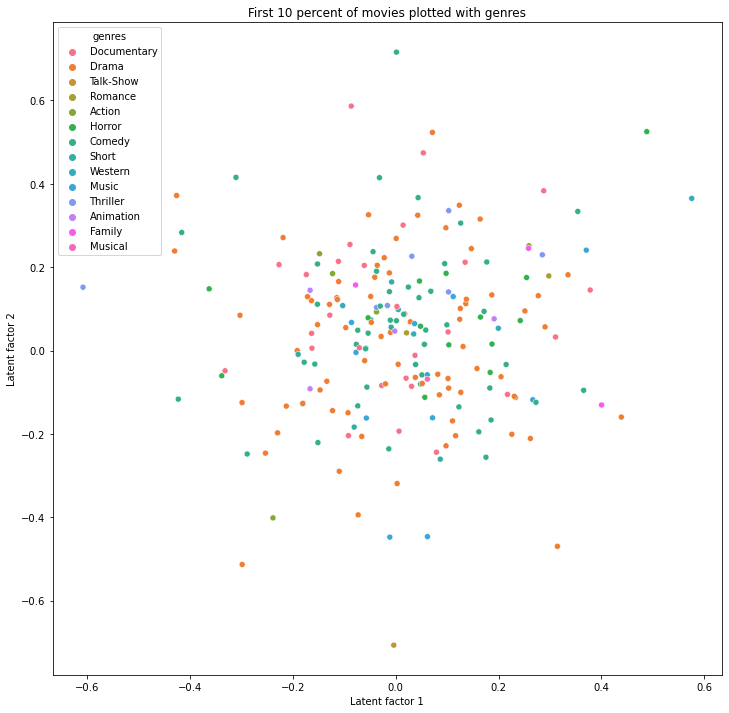

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [10]:
unique_tag_df = df[~df.fillna(',')['genres'].str.contains(',')]

plot_graph(unique_tag_df, colname='genres')

## Something's wrong
Something looks off. It seems like we might not be allocating the right latent representatiosn for each movie. I made the assumption that the `model.qi` would have row 0 correspond to movie 1, and row 1 to movie 2, and so on. But upon further investigation into surprise's documentation, this is not actually the case. Surprise will take the ID's from the raw data (i.e. 1: Dinosaur Planet, 2: Isle of Man TT, 3: Character, etc.), and map them to unique "inner ids". Let's try to navigate this mapping with functions from the `model.trainset` class.

In [11]:
# first let's read in the ratings file on which the specific model was trained
train_df = pd.read_csv('data/data_first_10p.csv')

# We'll use Dinosaur Planet (with a raw id of 1) as our guide
dino_df = train_df[train_df['movie'] == 1]

# the trainset only has ratings information, so what we can do is compare both rating informations and ensure that they line up
svd_dino_index = model.trainset.to_inner_iid(1)
svd_dino_ratings = np.array([rating for user, rating in model.trainset.ir[svd_dino_index]])
files_ratings = np.array(dino_df['rating'])

In [12]:
# svd_dino_ratings.sort()
# files_ratings.sort()

print(len(svd_dino_ratings))
print(len(files_ratings))

486
547


Hmmm... I thought this would work, but it did not. Let's continue investigating. Does Surprise drop some ratings?


In [13]:
# ensure that the model trainset has seen every 'raw index' from the files.
# in other words, we are checking to ensure that all movies from the training file are in this model
for i in range(0, train_df.movie.nunique() + 2):
    try:
        model.trainset.to_inner_iid(i)
    except:
        print(f'Could not find movie {i}')

Could not find movie 0
Could not find movie 1963


In [14]:
# check that the mapping makes sense (raw_id to inner_id to raw_id)
raw_id = 1
inner_id = model.trainset.to_inner_iid(raw_id)
raw_id == model.trainset.to_raw_iid(inner_id)

True

In [15]:
# Let's look at a less popular movie
train_df.groupby('movie')['rating'].count().sort_values()

movie
915         43
820         45
1858        54
1416        55
1383        58
         ...  
1307    121207
1220    134241
1145    140154
571     154832
1905    193941
Name: rating, Length: 1962, dtype: int64

In [16]:
# We'll use movie 915 then
raw_id = 915
svd_index = model.trainset.to_inner_iid(raw_id)
svd_list = model.trainset.ir[svd_index]
svd_list = sorted(svd_list, key=lambda x: model.trainset.to_raw_uid(x[0]))
svd_ratings = [rating for user, rating in svd_list]
svd_users = [model.trainset.to_raw_uid(user) for user, rating in svd_list]

rare_df = train_df[train_df.movie == raw_id].sort_values(by='user')

diff = len(rare_df) - len(svd_list)

svd_ratings = np.pad(svd_ratings, (0, diff), 'constant')
svd_users = np.pad(svd_users, (0, diff), 'constant')

rare_df['svd_users'] = svd_users
rare_df['svd_ratings'] = svd_ratings

In [17]:
rare_df.head(43)

,movie,user,rating,date,svd_users,svd_ratings
4673698,915,157846,5,2005-11-23,157846,5.0
4673705,915,305344,1,2005-07-27,305344,1.0
4673721,915,316155,3,2005-11-14,316155,3.0
4673716,915,387418,1,2005-11-09,387418,1.0
4673680,915,484675,4,2005-10-04,504620,3.0
4673701,915,504620,3,2005-09-18,582381,3.0
4673690,915,582381,3,2005-10-10,588285,1.0
4673688,915,588285,1,2005-10-31,759737,2.0
4673700,915,759737,2,2005-12-05,791911,3.0
4673702,915,791911,3,2005-10-28,825353,1.0


This is very interesting, so the svd model will actually remove some of the ratings from the original files. Let's see on average how many ratings does it remove. We will use average percentage

In [18]:
def percent_removed(raw_id):
    svd_index = model.trainset.to_inner_iid(raw_id)
    svd_list = model.trainset.ir[svd_index]
    svd_list = sorted(svd_list, key=lambda x: model.trainset.to_raw_uid(x[0]))
    svd_ratings = [rating for user, rating in svd_list]
    svd_users = [model.trainset.to_raw_uid(user) for user, rating in svd_list]

    rare_df = train_df[train_df.movie == raw_id].sort_values(by='user')

    diff = len(rare_df) - len(svd_list)
    
    return 100*diff / len(rare_df)

pr = total = 0
for i in range(1, len(train_df) + 5):
    try:
        pr += percent_removed(i)
        total += 1
    except:
        pass
    
print(f'Average percent removed {pr/total}')

Average percent removed 9.967457378049017


So on average, the algorithm will remove about 10% of the ratings from the ratings file. I could potentially look into whether that is a part of the algorithm, but for now let's get back to genre plotting.

## Back to Genre Plotting
Let's rearrange the dataframe so that we now pass the right latent factors to the right movies.

In [19]:
# Let's build the list that has all of the latent factors in the correct order
# the list will have at [LF1, LF2, ... , LFn]
sorted_LR = []

# range(1, model.trainset.n_items + 1) represents all of the raw ids from the training file
for index in range(1, model.trainset.n_items + 1):
    inner_id = model.trainset.to_inner_iid(index)
    vector_rep = model.qi[inner_id]
    sorted_LR.append(vector_rep)
    
sorted_LR = np.array(sorted_LR) # this will make for easier indexing

In [29]:
# Let's do the t-SNE dimension reduction
latent_rep_2d = TSNE(random_state=0, learning_rate=50).fit_transform(sorted_LR)

In [30]:
df['latent_x'] = latent_rep_2d[:, 0]
df['latent_y'] = latent_rep_2d[:, 1]

In [31]:
unique_tag_df = df[~df.fillna(',')['genres'].str.contains(',')]
unique_tag_df['genres'].unique()

array(['Documentary', 'Drama', 'Talk-Show', 'Romance', 'Action', 'Horror',
       'Comedy', 'Short', 'Western', 'Music', 'Thriller', 'Animation',
       'Family', 'Musical'], dtype=object)

## Most Common (Correct)

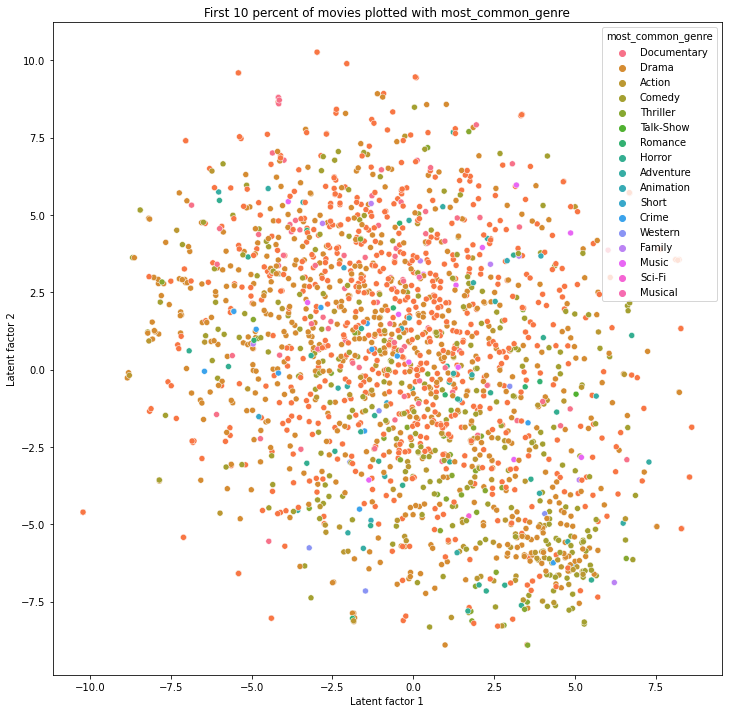

In [44]:
plot_graph(df, colname='most_common_genre')
plt.savefig('visuals/10p_plot_most_common.png')

This is a much better graph than the hairball we were dealing with before. However, this graph is still not as informative as we would like. It's hard to tell if there is any sort of clustering based on genres from this graph. Let's keep going...

## Unique Genres

In [33]:
# plot_graph(df, colname='unique_genres')

## Plotting with Tent-poles
I anticipate this to be one of the most promising approaches

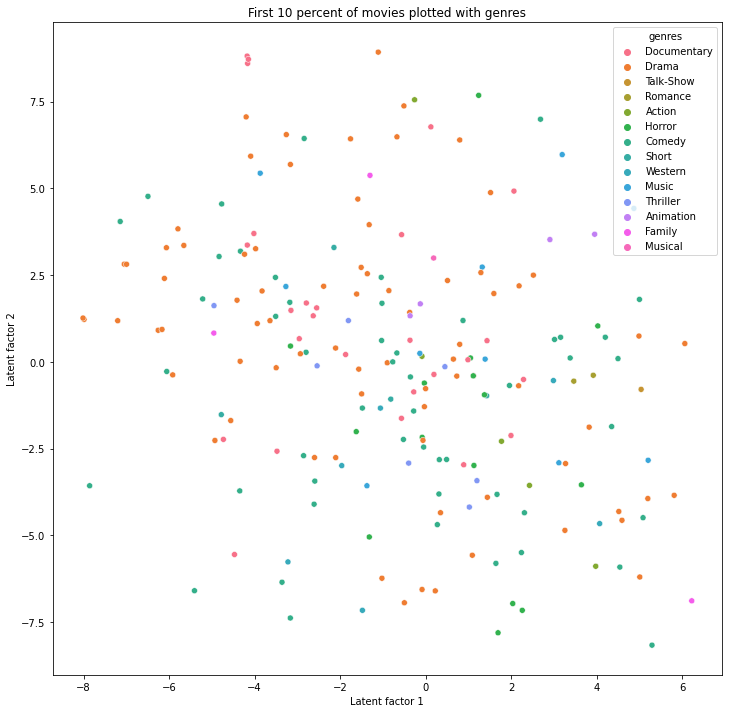

In [34]:
plot_graph(unique_tag_df, colname='genres')

In [26]:
unique_tag_df.groupby(by='genres')['ID'].count().sort_values()

genres
Musical         1
Talk-Show       1
Romance         2
Family          3
Animation       4
Short           4
Action          5
Western         6
Thriller        7
Music          10
Horror         15
Documentary    27
Comedy         51
Drama          76
Name: ID, dtype: int64

In [27]:
popular_unique_tag_df = unique_tag_df[unique_tag_df['genres'].isin(['Music','Horror','Documentary', 'Comedy', 'Drama'])]
print(popular_unique_tag_df.genres.unique())
print(popular_unique_tag_df.groupby(by='genres')['ID'].count().sort_values())

['Documentary' 'Drama' 'Horror' 'Comedy' 'Music']
genres
Music          10
Horror         15
Documentary    27
Comedy         51
Drama          76
Name: ID, dtype: int64


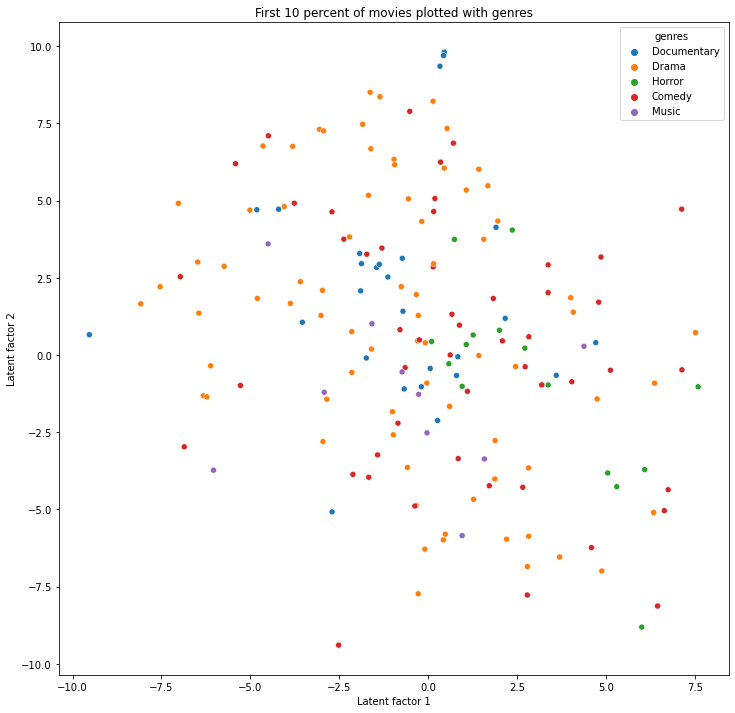

In [45]:
plot_graph(popular_unique_tag_df, colname='genres')
plt.savefig('visuals/10p_plot_with_genres.png')